# 2024-01-20 21 - Tables and plots for paper -- experiment suite v2.ipynb
Copy of `NB 15`. TO DO Jan 20, refactor this notebook with new abstractions to reuse data processing and plots

## Fetching runs

In [15]:
import wandb
from math import isnan 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import wandb
from tqdm import tqdm
# from cycler import cycler
import matplotlib as mpl
from IPython.display import Markdown, display
    
api = wandb.Api()
project = "Autoformer-javierdev"
workspace = "alelab"

experiment_tags = [
    'e0_exploration_runs'
]

# get all runs that both: 1.  match any experiment tag and 2. are finished
runs = api.runs(f"{workspace}/{project}",
                {"$and": [
                    {"tags": {"$in": experiment_tags}},
                    #{"state": "finished"}
                ]})

runs = [run for run in runs if run.id == "yygmribz"]

def tag_experiment(run):
    for tag in experiment_tags:
        if tag in run.tags:
            return tag
    return ''

runs

[<Run alelab/Autoformer-javierdev/yygmribz (crashed)>]

In [17]:
import wandb
from math import isnan 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import wandb
from tqdm import tqdm
# from cycler import cycler
import matplotlib as mpl
from IPython.display import Markdown, display
    
api = wandb.Api()
project = "Autoformer-javierdev"
workspace = "alelab"

experiment_tags = [
    'e0_exploration_runs'
]

# get all runs that both: 1.  match any experiment tag and 2. are finished
runs = api.runs(f"{workspace}/{project}",
                {"$and": [
                    {"tags": {"$in": experiment_tags}},
                    #{"state": "finished"}
                ]})

runs = [run for run in runs if run.id == "yygmribz"]

def tag_experiment(run):
    for tag in experiment_tags:
        if tag in run.tags:
            return tag
    return ''

# filter runs by 

all_runs = []
run_counter = 0
for run in tqdm(runs):
    run_counter += 1
    for split in ["train", "test","val"]:
        for metric in ["mse",]:
            pred_len = run.config["pred_len"]
            metrics = np.zeros(pred_len)
            for i in range(pred_len):
                run_dict = {**run.config}
                #run_dict["constraint_level"] = constraint_level
                run_dict[f"{metric}"] = run.summary[f"{metric}/{split}/{i}"]
                #run_dict[f"{metric}"] = run.summary.get(f"{metric}/{split}/{i}",run.summary.get(f"mse/{split}/{i}",np.nan)) #god forgive me for this line
                run_dict["step"]=i
                run_dict["epoch"]=run.summary["epoch"]
                run_dict["infeasible_rate"]=run.summary[f"infeasible_rate/{split}"]
                run_dict["infeasibles"]=run.summary[f"infeasibles/{split}"]
                run_dict[f"multiplier"] = run.summary[f"multiplier/{i}"] if split == "train" else np.nan
                run_dict["split"] = split
                run_dict["run_id"] = run.id
                # Get either Constrained/ or ERM/ from the run name, then append model name.
                #print("run.name", run.name)
                #debug if ERM run
                run_dict["Algorithm"] = f"{run.name.split('/')[0]} {run.config['model']}"
                #run_dict["sweep_id"] = run.sweep.id
                #print("Algorithm", run_dict["Algorithm"])

                # Get the experiment tag
                run_dict["experiment_tag"] = tag_experiment(run)

                # To better plot constrained vs ERM
                #TODO this is a hack while I consolidate the tags. 
                run_dict["type"] = "ERM" if run.config['dual_lr'] == 0 else "Constrained"

                all_runs.append(run_dict)
print(f"Fetched {run_counter} runs")
df = pd.DataFrame(all_runs)
print(f"Total records: {(df.shape)}")
print(f"Total runs: {df.run_id.nunique()}")

100%|██████████| 1/1 [00:00<00:00, 141.08it/s]

Fetched 1 runs
Total records: (288, 79)
Total runs: 1


In [35]:
# artifact = run.use_artifact('alelab/Autoformer-javierdev/predictions:v0', type='dataset')
# artifact_dir = artifact.download()

In [44]:
# Load pytorch model
import torch
model_dir = "../checkpoints/electricity_autoformer_Autoformer_custom_ftM_sl96_ll48_pl96_dm512_nh8_el2_dl1_df2048_fc3_ebtimeF_dtTrue_Exploration_0/checkpoint.pth"
model = torch.load(model_dir)


In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [8]:
from utils.load_model import load_model
# This function abstracts getting the best model from a run.
load_model("alelab","Autoformer-javierdev","y87aifeg")

Model(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(321, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(321, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0): EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): ProbAttention(
      

In [8]:
# TODO DELETEME: For now checking just informer
df = df[df.Algorithm.str.contains("Informer")]

# Calc the pearson of loss vs step to check linearity

In [6]:
import scipy
from scipy.stats import pearsonr
# Calculate pearson
pearsonr()

<function scipy.stats.stats.pearsonr(x, y)>

Looks good:

In [11]:
only_constrained_on_first_runs=(df.experiment_tag.isin(["e1_weather_10e_statinformed","e2_electricity_10e_statinformed"])) & (df.type == "Constrained")
not_e1_e2 = ~df.experiment_tag.isin(["e1_weather_10e_statinformed","e2_electricity_10e_statinformed"])
df[only_constrained_on_first_runs | not_e1_e2] \
    .groupby(['experiment_tag','type']).run_id.nunique().reset_index()

,experiment_tag,type,run_id
0,e12_erm_electricity_dlfix,ERM,12
1,e14_constrained_electricity_dlfix,Constrained,6


In [12]:
df = df[only_constrained_on_first_runs | not_e1_e2]

In [13]:
df[['run_id',"sweep_id",'Algorithm','model','constraint_level','pred_len','epoch',"split"]] \
    .drop_duplicates().sort_values(["pred_len",'Algorithm','model',"constraint_level"])

,run_id,sweep_id,Algorithm,model,constraint_level,pred_len,epoch,split
2304,f07ytw0r,xmsqlpzj,Electricity-StatInformed-10e-Constrained Informer,Informer,0.170,96,10,train
2400,f07ytw0r,xmsqlpzj,Electricity-StatInformed-10e-Constrained Informer,Informer,0.170,96,10,test
2496,f07ytw0r,xmsqlpzj,Electricity-StatInformed-10e-Constrained Informer,Informer,0.170,96,10,val
2016,l6enf00m,xmsqlpzj,Electricity-StatInformed-10e-Constrained Informer,Informer,0.175,96,10,train
2112,l6enf00m,xmsqlpzj,Electricity-StatInformed-10e-Constrained Informer,Informer,0.175,96,10,test
2208,l6enf00m,xmsqlpzj,Electricity-StatInformed-10e-Constrained Informer,Informer,0.175,96,10,val
0,2fctkhfu,xmsqlpzj,Electricity-StatInformed-10e-Constrained Informer,Informer,0.183,96,10,train
96,2fctkhfu,xmsqlpzj,Electricity-StatInformed-10e-Constrained Informer,Informer,0.183,96,10,test
192,2fctkhfu,xmsqlpzj,Electricity-StatInformed-10e-Constrained Informer,Informer,0.183,96,10,val
6336,mgd00ji1,jsh6vre8,Electricity-StatInformed-ERM-10e Informer,Informer,-1.000,96,10,train


## Data processing
1. Impute seed for the first batch of runs
2. Create aggregate dataset of metrics per experiment `(data_path,model,pred_len,constraint_level)`
3. Add any other useful columns

In [14]:
df.seed.unique()

array([0])

It seems that the seeds didn't get properly logged, but we can confirm that the results have variance so it's not just the same run three times.

In [15]:
# sanity checking that at least results are different
#df.groupby(["Algorithm","model","constraint_level","pred_len"])['run_id'].nunique().reset_index()

dcp = df.copy()
run_means=dcp.groupby(["model","constraint_level","pred_len","data_path",'run_id'])['mse'].describe().round(3).reset_index()

# Verifying t
run_means.groupby(["model","constraint_level","pred_len","data_path"]).agg({'mean':list}).reset_index().sample(25)

ValueError: Cannot take a larger sample than population when 'replace=False'

### Broadcast ERM runs with constraint levels (`df_to_plot`)

In [16]:
df_constrained = df.query('type=="Constrained"').copy()
df_erm = df.query('type=="ERM"').copy()
#(data_path,model,pred_len,constraint_level,constrained_unconstraled)
distinct_constraints = df_constrained[['data_path','model','pred_len','constraint_level']].drop_duplicates()

# crossjoin the ERM mse to all constraint levels
df_erm_w_broadcasted_constraint_levels = df_erm.drop(columns=['constraint_level']).merge(distinct_constraints,on=['data_path','model','pred_len'],how='left')
df_to_plot = pd.concat([df_constrained,df_erm_w_broadcasted_constraint_levels],axis=0)

# sanity check
display(df_erm_w_broadcasted_constraint_levels.shape)
print(f"Three constraints per experiment, broadcasted dataset size be equal to {df_erm.shape[0]*3}")
display(df_to_plot.shape)
print(f"Final dataset size should be equal to {df_constrained.shape[0]+df_erm.shape[0]*3}")

(17280, 76)

Three constraints per experiment, broadcasted dataset size be equal to 36288


(19872, 76)

Final dataset size should be equal to 38880


### Add constraint violation metric

In [17]:
# Adding the constraint violation column
df_to_plot["constraint_violation"] = (df_to_plot.mse-df_to_plot.constraint_level).clip(lower=0)
df_to_plot['is_infeasible'] = (df_to_plot.constraint_violation>0)*1

# sanity check
dd=df_to_plot[['run_id','model','type','step','mse','constraint_level','constraint_violation','is_infeasible']] 
print("For ERM")
display(dd.query('type=="ERM"').query('constraint_violation>0').head())
print("For Constrained")
display(dd.query('type=="Constrained"').query('constraint_violation>0').head())


For ERM


,run_id,model,type,step,mse,constraint_level,constraint_violation,is_infeasible
3170,4td0j6pm,Informer,ERM,0,0.190189,0.188,0.002189,1
3173,4td0j6pm,Informer,ERM,1,0.192386,0.188,0.004386,1
3202,4td0j6pm,Informer,ERM,11,0.194134,0.193,0.001134,1
3203,4td0j6pm,Informer,ERM,11,0.194134,0.188,0.006134,1
3204,4td0j6pm,Informer,ERM,12,0.205891,0.198,0.007891,1


For Constrained


,run_id,model,type,step,mse,constraint_level,constraint_violation,is_infeasible
23,2fctkhfu,Informer,Constrained,23,0.184417,0.183,0.001417,1
59,2fctkhfu,Informer,Constrained,59,0.186358,0.183,0.003358,1
77,2fctkhfu,Informer,Constrained,77,0.184950,0.183,0.001950,1
94,2fctkhfu,Informer,Constrained,94,0.183245,0.183,0.000245,1
95,2fctkhfu,Informer,Constrained,95,0.190577,0.183,0.007577,1


### Add infeasible rate (missing on ERM)

In [18]:
# # Add infeasible count in the last step
# dd=df_to_plot.query('type=="ERM" and split=="test" and pred_len==96').copy()
# dd['is_infeasible'] = (dd.constraint_violation>0)*1
# dd[['run_id','pred_len',"constraint_level","split",'step','mse','constraint_violation','is_infeasible']].sort_values(["run_id","constraint_level","split","step"]).head(98)

### Aggregate results
Summarize all three runs into metrics per split by averaging mse and constraint levels.

In [19]:
#TO DO in progress: how to compute the infeasibility rate for the ERM runs. I already have the is_infeasible flag on each step. Need to average properly.
# Can be cross checked in constrained runs.
df_to_plot.groupby(["Algorithm",'run_id', #Harmless carryover col for legacy purposes (verified the counts are the same)
    "model",'type',"constraint_level","pred_len","data_path",
    "split"])['is_infeasible'].sum()

Algorithm                                          run_id    model     type         constraint_level  pred_len  data_path        split
Electricity-StatInformed-10e-Constrained Informer  0ebcuwkk  Informer  Constrained  0.188             192       electricity.csv  test     192
                                                                                                                                 train     26
                                                                                                                                 val      192
                                                   2fctkhfu  Informer  Constrained  0.183             96        electricity.csv  test      96
                                                                                                                                 train      5
                                                                                                                                         ... 
Electricity-S

In [20]:
# Calculate mean and std for mse and constraint_violation. Rename them mean_{metric} and std_{metric

summary_metrics_per_run = df_to_plot.groupby([
    "run_id",
    "Algorithm", #Harmless carryover col for legacy purposes (verified the counts are the same)
    "model",'type',"constraint_level","pred_len","data_path",
    "split"
    ])['mse','constraint_violation','infeasible_rate','run_id'].aggregate(
        mse=('mse','mean'),
        #std_mse=('mse','std'),
        mcv=('constraint_violation','mean'),
        #std_mcv=('constraint_violation','std'),
        mean_infeasible_rate=('infeasible_rate','mean'),
        #std_infeasible_rate=('infeasible_rate','std'),
        run_count=('run_id','nunique')
        ).reset_index().round(5)
summary_metrics = summary_metrics_per_run.groupby([
    "Algorithm", #Harmless carryover col for legacy purposes (verified the counts are the same)
    "model",'type',"constraint_level","pred_len","data_path",
    "split"]).aggregate(
        mse=('mse','mean'),
        std_mse=('mse','std'),
        mcv=('mcv','mean'),
        std_mcv=('mcv','std'),
        mean_infeasible_rate=('mean_infeasible_rate','mean'),
        std_infeasible_rate=('mean_infeasible_rate','std'),
        run_count=('run_count','mean')
    ).reset_index()
display(summary_metrics_per_run.shape)
display(summary_metrics.shape)
summary_metrics.head()

/home/jporras/miniconda3/envs/autoformer/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


(72, 12)

(36, 14)

,Algorithm,model,type,constraint_level,pred_len,data_path,split,mse,std_mse,mcv,std_mcv,mean_infeasible_rate,std_infeasible_rate,run_count
0,Electricity-StatInformed-10e-Constrained Informer,Informer,Constrained,0.170,96,electricity.csv,test,0.34513,NaN,0.17513,NaN,1.00000,NaN,1.0
1,Electricity-StatInformed-10e-Constrained Informer,Informer,Constrained,0.170,96,electricity.csv,train,0.16468,NaN,0.00107,NaN,0.65625,NaN,1.0
2,Electricity-StatInformed-10e-Constrained Informer,Informer,Constrained,0.170,96,electricity.csv,val,0.23331,NaN,0.06331,NaN,0.99934,NaN,1.0
3,Electricity-StatInformed-10e-Constrained Informer,Informer,Constrained,0.175,96,electricity.csv,test,0.35094,NaN,0.17594,NaN,1.00000,NaN,1.0
4,Electricity-StatInformed-10e-Constrained Informer,Informer,Constrained,0.175,96,electricity.csv,train,0.16637,NaN,0.00066,NaN,0.18750,NaN,1.0


## Plots

### ERM vs. Constrained on test split (single run)
TO DO: Reproduce the ERM vs constrained per model for each window size. Try to unify into one plot if possible.

In [21]:
unique_run_ids = df_to_plot.sample(frac=1,random_state=42).groupby(["model",'type',"constraint_level","pred_len","data_path"])['run_id'].head(1)

In [22]:
# display(df.query('type=="Constrained" and pred_len==96 and data_path=="electricity.csv"')[['run_id','model','sweep_id','type','constraint_level','data_path','experiment_tag']].groupby(['run_id','model','sweep_id','type','constraint_level','data_path','experiment_tag']).size().reset_index().sort_values(0,ascending=False))

In [23]:
# # Query ERM runs with pred_len96 constraint_level: 0.17, on weather.csv
# display(df.query('type=="ERM" and pred_len==96 and data_path=="electricity.csv"')[['run_id','model','sweep_id','type','constraint_level','data_path','experiment_tag']].groupby(['run_id','model','sweep_id','type','constraint_level','data_path','experiment_tag']).size().reset_index().sort_values(0,ascending=False))
# display(df_to_plot.query('type=="ERM" and pred_len==96 and data_path=="electricity.csv"')[['run_id','model','sweep_id','type','constraint_level','data_path','experiment_tag']].groupby(['run_id','model','sweep_id','type','constraint_level','data_path','experiment_tag']).size().reset_index().sort_values(0,ascending=False))

In [24]:
# sanity checking that at least results are different
#df.groupby(["Algorithm","model","constraint_level","pred_len"])['run_id'].nunique().reset_index()

dcp = df.copy()
run_means=dcp.groupby(["model","constraint_level","pred_len","data_path",'run_id'])['mse'].describe().round(3).reset_index()

# Verifying t
run_means.groupby(["model","constraint_level","pred_len","data_path"]).agg({'mean':list}).reset_index().sample(25)

ValueError: Cannot take a larger sample than population when 'replace=False'

In [25]:
#deleteme
to_plot_train = df_to_plot[(df_to_plot.split=='train')].copy()
to_plot_test = df_to_plot[(df_to_plot.split=='test')].copy()

In [26]:
to_plot_train.query("").groupby('run_id')['mse'].mean()

ValueError: expr cannot be an empty string

In [27]:
display(to_plot_train.query('Algorithm=="Electricity-StatInformed-10e-Constrained PatchTST"').groupby(['run_id','pred_len'])['mse'].mean())
display(to_plot_test.query('Algorithm=="Electricity-StatInformed-10e-Constrained PatchTST"').groupby(['run_id','pred_len'])['mse'].mean())

Series([], Name: mse, dtype: float64)

Series([], Name: mse, dtype: float64)

## Main plots

[0.183 0.175 0.17 ]


### Dataset: electricity.csv pred_len: 96 constraint_level: 0.183

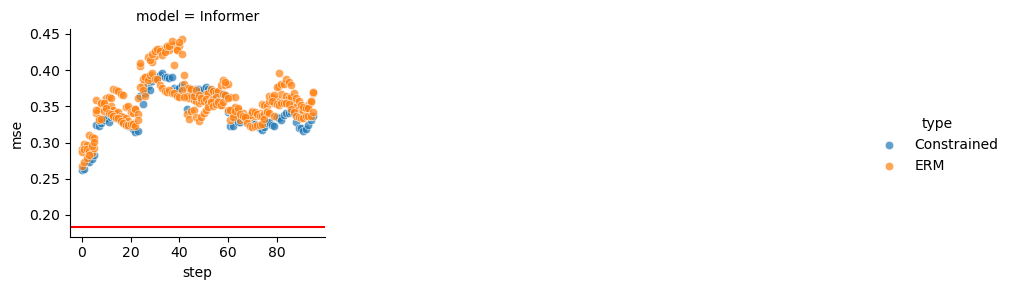

### Dataset: electricity.csv pred_len: 96 constraint_level: 0.175

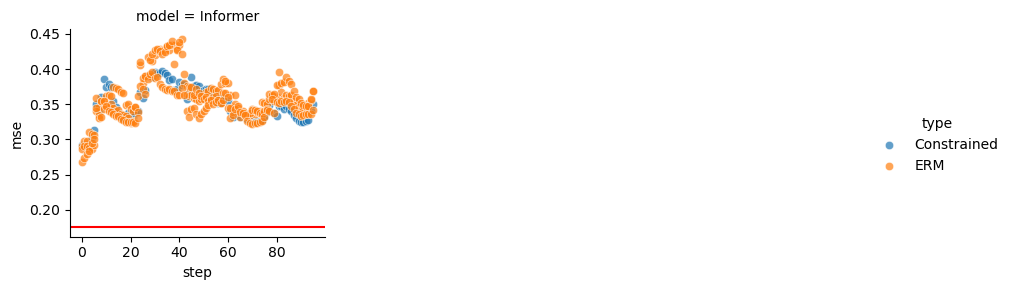

### Dataset: electricity.csv pred_len: 96 constraint_level: 0.17

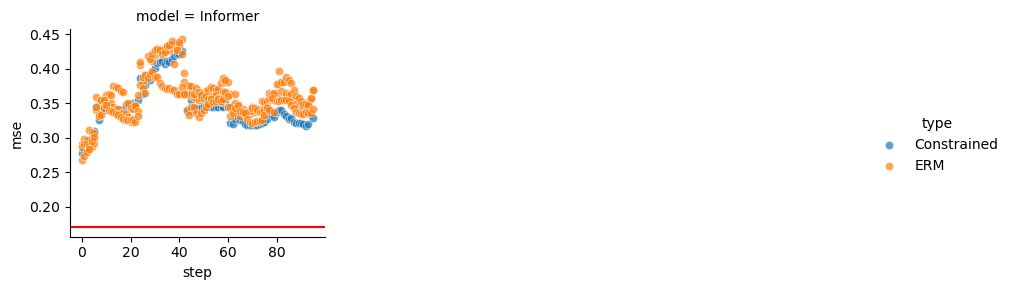

[0.198 0.193 0.188]


### Dataset: electricity.csv pred_len: 192 constraint_level: 0.198

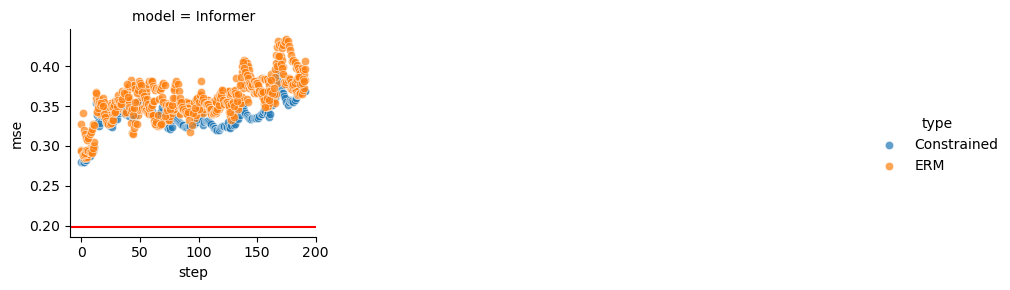

### Dataset: electricity.csv pred_len: 192 constraint_level: 0.193

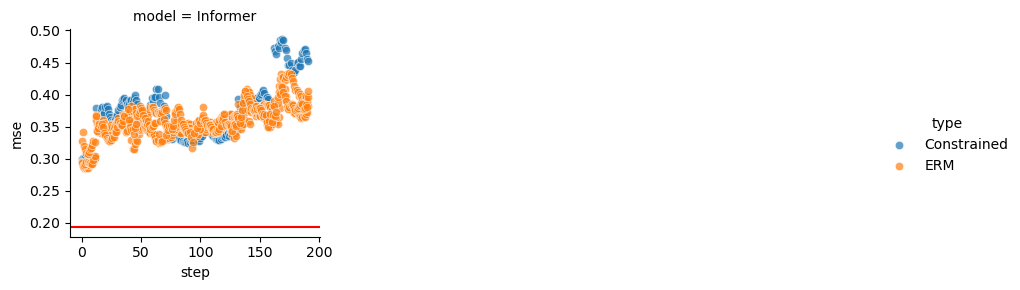

### Dataset: electricity.csv pred_len: 192 constraint_level: 0.188

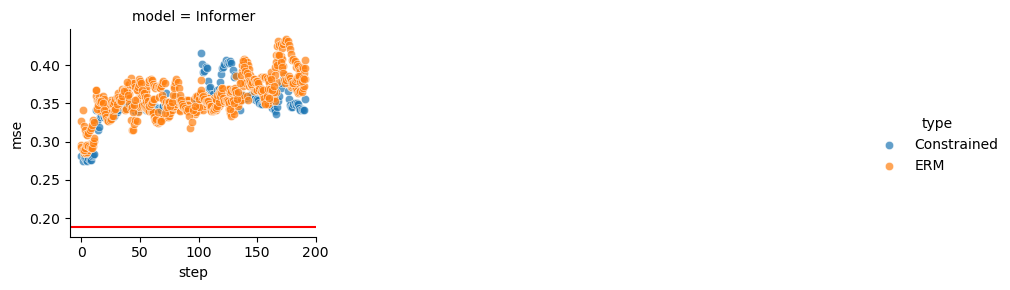

[nan]


### Dataset: electricity.csv pred_len: 336 constraint_level: nan

ValueError: Number of rows must be a positive integer, not 0

<Figure size 900x0 with 0 Axes>

In [34]:
to_plot = df_to_plot[(df_to_plot.split=='test')].copy()
for (data_path,pred_len), series in to_plot.groupby(['data_path',"pred_len"]):
    constraints = series.constraint_level.unique()
    print(constraints)
    constraints = constraints[constraints!=-1] # to iterate over all constraints explored.
    for constraint_level in constraints:
        display(Markdown(f"### Dataset: {data_path} pred_len: {pred_len} constraint_level: {constraint_level}"))
        plot_series = series[series["constraint_level"]==constraint_level]
        
        #means_per_experiment = plot_series.groupby(['pred_len','constraint_level','Algorithm','model','epoch','type'])['mse'].mean().reset_index()
        #display(means_per_experiment)
        # do a pivot where model are the rows, and the columns constrained and unconstrained
        #display(means_per_experiment.pivot(index=['model'], columns='type', values='mse').reset_index())

        # sns.scatterplot(x="step", y="mse", hue="Algorithm",style="split", data=plot_series)
        
        # plt.axhline(y=constraint_level, color='r', linestyle='-')
        # plt.title(f"Pred Length: {pred_len}, Constraint_level: {constraint_level}")
        # plt.show()

        # This same scatterplot but in a grid by algorithm. 
        g = sns.FacetGrid(plot_series, col="model", hue="type",col_wrap=3)
        g.map(sns.scatterplot, "step", "mse", alpha=.7) 
        g.add_legend()
        # add the hline
        for ax in g.axes:
            ax.axhline(y=constraint_level, color='r', linestyle='-')
        plt.show()
        # export this plot to latex. Remove the dot in constraint_level decimal
        g.savefig(f"figures/constrained_vs_erm_{data_path}_{pred_len}_{str(constraint_level).replace('.','')}.png")
        # Fix [Errno 2] No such file or directory: 'figures/electricity.csv_96_0.17_individual.png'


### ERM on multiple algorithms
As a front page chart to illustrate the problem

In [ ]:
#TODO

### Loss shaping single instance qualitative analysis

### Plotting dual variables

In [ ]:
df_to_plot[['run_id','pred_len','constraint_level','data_path','model','type']].drop_duplicates().query("data_path=='weather.csv' and model=='Reformer' and type=='Constrained'")

,run_id,pred_len,constraint_level,data_path,model,type
109872,p9izzn2r,96,0.556,weather.csv,Reformer,Constrained
110160,b1adswkj,96,0.553,weather.csv,Reformer,Constrained
110448,dowv2wrc,96,0.516,weather.csv,Reformer,Constrained
110736,i7gx5ivx,192,0.665,weather.csv,Reformer,Constrained
111312,v4rwuch4,192,0.567,weather.csv,Reformer,Constrained
111888,mitm69y2,192,0.553,weather.csv,Reformer,Constrained
112464,chbkcq99,336,0.970,weather.csv,Reformer,Constrained
113472,749ywu49,336,0.741,weather.csv,Reformer,Constrained
114480,fe29o3il,336,0.682,weather.csv,Reformer,Constrained
115488,n1dluqy8,720,0.912,weather.csv,Reformer,Constrained


In [ ]:
constrained_runs = df_to_plot.query('type=="Constrained"').copy()
# Sum the multilpiers, fill with 0
key_cols=['run_id','model','pred_len','constraint_level','data_path']
multiplier_sum=constrained_runs.groupby(key_cols)['multiplier'].sum().reset_index()

#TO DO: plot MSE 
# get test mse
test_mses=constrained_runs.query('split=="test"').groupby(key_cols)['mse'].mean().reset_index()
mult_vs_test_mse=multiplier_sum.merge(test_mses,on=key_cols)
#sns.scatterplot(x="multiplier", y="mse", hue="constraint_level",style="pred_len", data=mult_vs_test_mse)
#g = sns.FacetGrid(mult_vs_test_mse, col="model",row='data_path',style="pred_len")
# scatterplot with hue="constraint_level",style="pred_len"
#g.map(sns.scatterplot, "multiplier", "mse", alpha=.7,)#sns.scatterplot(**args,hue="constraint_level",style="pred_len",alpha=0.3)
#g.map(sns.scatterplot, "multiplier", "mse",alpha=.7)

In [ ]:
# #df_to_plot.query('split=="train" and pred_len==96').run_id.head(1)
# #mult_cols = [f"multiplier/{i}" for i in range(0,96)]
# # Plot for every constraint level in the 96 pred len window
# #for pred_len in df_to_plot.pred_len.unique():
# display(Markdown(f"# Multipliers for window of {pred_len}"))
# # sns.scatterplot(x="step", y="multiplier", hue="model",style="constraint_level", 
# #     data=df_to_plot.query(f"split=='train' and type=='Constrained' and pred_len=={96} and data_path=='weather.csv'"))
# # same plot, but grid with one plot per model
# dd = df_to_plot#df_to_plot.query("run_id=='6fgam2dx' and split=='train'")#.query(f"split=='train' and type=='Constrained' and pred_len==96 and data_path=='electricity.csv' and model=='Reformer' and constraint_level==0.157")
# dd_test = df_to_plot#df_to_plot.query("run_id=='6fgam2dx' and split=='test'")#.query(f"split=='test' and type=='Constrained' and pred_len==96 and data_path=='electricity.csv' and model=='Reformer' and constraint_level==0.157")

# #print(dd_test.constraint_level.unique())
# test_set_plus_multipliers = dd[['step','multiplier']].merge(dd_test[['step','split','mse']],on='step')

# unioned = pd.concat([dd[['step','split','multiplier','mse']],test_set_plus_multipliers[['step','split','multiplier','mse']]])

# display(unioned)


# display(test_set_plus_multipliers)

# #constraint_level==0.553
# # mult on x, mse@train and mse@test on y. hue=split
# # Add step over every point
# sns.scatterplot(unioned,x="multiplier", y="mse",hue='split', alpha=.3,legend='full')



# g = sns.FacetGrid(dd, col="model", row="constraint_level")
# g.map(sns.scatterplot, "step", "multiplier", alpha=.3)
# #g.map(sns.scatterplot, "step", "mse", alpha=.3)

### More random explorations
Ideas: 
1. Loss over time
2. Infeasibility rate over time
3. Loss shape across epochs (see how it evolves)
4. Plotting dual variables

## Result tables
1. Reproduce the pivot table from notebook 11, perhaps add standard deviation reports.
2. Explore and find other interesting table visualziation

In [31]:
#Note, variance is nan because there is only one run per parameter set
#weather = summary_metrics.query('data_path=="weather.csv"').copy()
electricity = summary_metrics.query('data_path=="electricity.csv"').copy()
for name,dataset in [ ('electricity',electricity)]:
#for name,dataset in [('weather',weather), ('electricity',electricity)]:
    display(Markdown(f"# {name}"))
    tp2=dataset.copy(deep=True)
    #tp2=weather.query('split=="test"').copy()
    # Compute 'infeasible amount' as the difference between the mse and the constraint_level, 0 if mse < constraint
    #tp2['mean_violation']=tp2.apply(lambda x: max(0,x['mse']-x['constraint_level']),axis=1)
    
    # Split into constrained and ERM
    tp2_constrained=tp2.query('type=="Constrained"').copy()
    tp2_erm_baseline=tp2.query('type=="ERM"').copy()

    distinct_constraints = tp2_constrained[['pred_len','model','constraint_level']].drop_duplicates()

    # crossjoin the ERM mse to all constraint levels
    #tp2_erm_baseline_broadcasted = tp2_erm_baseline.drop(columns=['constraint_level']).merge(distinct_constraints,on=['pred_len','model'],how='left')

    #display(tp2_erm_baseline_broadcasted[['type','model','constraint_level','mse']].head())

    # concat back together to compute mean_violation
    #tp2=pd.concat([tp2_constrained,tp2_erm_baseline_broadcasted],axis=0)

    #tp2['mean_violation']=tp2.apply(lambda x: max(0,x['mse']-x['constraint_level']),axis=1)

    # Sanity check show the mean_violation for the ERM runs
    #display(tp2.query('type=="ERM"')[['type','model','constraint_level','mse','mean_violation']].head())


    #GROUPING TEH VALS
    grouped_values=tp2.groupby(['pred_len','constraint_level','model','type'])[[
        'mse','mcv',
        'std_mse','std_mcv',
        'mean_infeasible_rate','std_infeasible_rate']].mean().reset_index()
    #grouped_constrained = grouped_values[grouped_values.type=='Constrained'].copy()
    #grouped_erm_baseline=grouped_values[grouped_values.type=='ERM'].copy()

    # best_constraints is the constraint for each model and pred_len that minimizes mean_violation. show min and argmin
    #best_constraints_per_window = grouped_values.query('type=="Constrained"').groupby(['pred_len']).apply(lambda x: x.loc[x['mean_violation'].idxmin()]).reset_index(drop=True)[['pred_len','type','constraint_level','mean_violation','mse']]
    # instead of best constraints, show all constraint levels.

    # join best_constraints and grouped_values to get the mse and mean_violation for the best constraint
    #best_constrained=grouped_values.merge(best_constraints_per_window[['pred_len','constraint_level']],on=['pred_len','constraint_level'],how='inner')


    # crossjoin the ERM mse to all constraint levels
    ##grouped_erm_baseline_broadcasted = grouped_erm_baseline.drop(columns=['constraint_level']).merge(grouped_constrained[['pred_len','model','constraint_level']].drop_duplicates(),on=['pred_len','model'],how='left')

    # Pivot of models versus constrained and ERM, values are mse and mse_diff
    all_results = grouped_values#pd.concat([grouped_constrained,grouped_erm_baseline_broadcasted],axis=0)
    # Pivot all results, sort ascending by pred_len, then mean_violation on constrained

    pivoted=all_results.pivot(
        index=['pred_len','constraint_level'], 
        columns=['type','model'], 
        values=['mse','std_mse','mcv','std_mcv','mean_infeasible_rate','std_infeasible_rate']
    ).query('constraint_level>0').round(4)
    simplified = all_results.pivot(
        index=['pred_len','constraint_level'],
        columns=['type','model'],
        values=['mse','mcv']
    )
    pd.set_option('display.max_columns', None)
    print("SIMPLIFIED 192 MSE")
    # show all pred lengths (index)
    for pred_len in [96, 192, 336, 720]:            
        print(simplified.index.get_level_values(0).unique())
        simp_mse_192=simplified[simplified.index.get_level_values(0)==pred_len][['mse']]
        sim_mcv_192=simplified[simplified.index.get_level_values(0)==pred_len][['mcv']]

        # Flatten the multiindex
        def prettify(d):
            d = d.copy()
            d.columns = d.columns.map('_'.join)
            return d.style.format(precision=3)
        # display(prettify(simp_mse_192))
        print(f"SIMPLIFIED {pred_len} MCV")
        display(prettify(sim_mcv_192))
    print("FULL")
    ## deleteme debug block
    if name=='electricity':
        print("picking out for debugging")
        pivoted_electricity=pivoted
    ##
    display(pivoted)
    #reformer works best on weather.

# electricity

SIMPLIFIED 192 MSE
Int64Index([96, 192], dtype='int64', name='pred_len')
SIMPLIFIED 96 MCV


Int64Index([96, 192], dtype='int64', name='pred_len')
SIMPLIFIED 192 MCV


Int64Index([96, 192], dtype='int64', name='pred_len')
SIMPLIFIED 336 MCV


,,mcv_Constrained_Informer,mcv_ERM_Informer
pred_len,constraint_level,,


Int64Index([96, 192], dtype='int64', name='pred_len')
SIMPLIFIED 720 MCV


,,mcv_Constrained_Informer,mcv_ERM_Informer
pred_len,constraint_level,,


FULL
picking out for debugging


mse              std_mse           \
type                      Constrained      ERM Constrained      ERM   
model                        Informer Informer    Informer Informer   
pred_len constraint_level                                             
96       0.170                 0.2477   0.2594         NaN   0.0058   
         0.175                 0.2497   0.2594         NaN   0.0058   
         0.183                 0.2459   0.2594         NaN   0.0058   
192      0.188                 0.2624   0.2740         NaN   0.0065   
         0.193                 0.2732   0.2740         NaN   0.0065   
         0.198                 0.2578   0.2740         NaN   0.0065   

                                  mcv              std_mcv           \
type                      Constrained      ERM Constrained      ERM   
model                        Informer Informer    Informer Informer   
pred_len constraint_level                                             
96       0.170                 0.0798   0.0896         NaN   0.0057   
         0.175                 0.0778   0.0852         NaN   0.0055   
         0.183                 0.0678   0.0789         NaN   0.0053   
192      0.188                 0.0763   0.0862         NaN   0.0063   
         0.193                 0.0846   0.0819         NaN   0.0060   
         0.198                 0.0645   0.0779         NaN   0.0056   

                          mean_infeasible_rate          std_infeasible_rate  \
type                               Constrained      ERM         Constrained   
model                                 Informer Informer            Informer   
pred_len constraint_level                                                     
96       0.170                          0.8852      1.0                 NaN   
         0.175                          0.7286      1.0                 NaN   
         0.183                          0.7113      1.0                 NaN   
192      0.188                          0.8040      1.0                 NaN   
         0.193                          0.7268      1.0                 NaN   
         0.198                          0.7631      1.0                 NaN   

                                    
type                           ERM  
model                     Informer  
pred_len constraint_level           
96       0.170                 0.0  
         0.175                 0.0  
         0.183                 0.0  
192      0.188                 0.0  
         0.193                 0.0  
         0.198                 0.0

In [ ]:
pivoted_electricity

mse                                  \
type                      Constrained      ERM Constrained        ERM   
model                        PatchTST PatchTST  Autoformer Autoformer   
pred_len constraint_level                                               
96       0.150                 0.1883   0.1916         NaN        NaN   
         0.157                    NaN      NaN      0.1507     0.1400   
         0.166                 0.1884   0.1916         NaN        NaN   
         0.169                    NaN      NaN      0.1541     0.1400   
         0.170                    NaN      NaN      0.1520     0.1400   
         0.194                 0.1889   0.1916         NaN        NaN   
192      0.151                 0.1903   0.1931         NaN        NaN   
         0.159                 0.1902   0.1931         NaN        NaN   
         0.173                    NaN      NaN      0.1763     0.1827   
         0.184                    NaN      NaN      0.1742     0.1827   
         0.195                 0.1906   0.1931         NaN        NaN   
         0.200                    NaN      NaN      0.1798     0.1827   
336      0.155                 0.2078   0.2107         NaN        NaN   
         0.192                 0.2080   0.2107         NaN        NaN   
         0.202                 0.2082   0.2107         NaN        NaN   
         0.232                    NaN      NaN      0.1849     0.1832   
         0.245                    NaN      NaN      0.1869     0.1832   
         0.256                    NaN      NaN      0.1851     0.1832   
720      0.215                    NaN      NaN      0.2379     0.2235   
         0.230                    NaN      NaN      0.2400     0.2235   
         0.246                    NaN      NaN      0.2241     0.2235   

                                                   std_mse           \
type                      Constrained      ERM Constrained      ERM   
model                        Reformer Reformer    PatchTST PatchTST   
pred_len constraint_level                                             
96       0.150                    NaN      NaN      0.0004   0.0003   
         0.157                 0.1824   0.1881         NaN      NaN   
         0.166                    NaN      NaN      0.0005   0.0003   
         0.169                 0.1832   0.1881         NaN      NaN   
         0.170                 0.1833   0.1881         NaN      NaN   
         0.194                    NaN      NaN      0.0003   0.0003   
192      0.151                    NaN      NaN      0.0003   0.0003   
         0.159                    NaN      NaN      0.0003   0.0003   
         0.173                 0.2074   0.2150         NaN      NaN   
         0.184                 0.2086   0.2150         NaN      NaN   
         0.195                    NaN      NaN      0.0001   0.0003   
         0.200                 0.2108   0.2150         NaN      NaN   
336      0.155                    NaN      NaN      0.0002   0.0003   
         0.192                    NaN      NaN      0.0001   0.0003   
         0.202                    NaN      NaN      0.0002   0.0003   
         0.232                 0.2163   0.2112         NaN      NaN   
         0.245                 0.2177   0.2112         NaN      NaN   
         0.256                 0.2192   0.2112         NaN      NaN   
720      0.215                 0.2284   0.2250         NaN      NaN   
         0.230                 0.2295   0.2250         NaN      NaN   
         0.246                 0.2325   0.2250         NaN      NaN   

                                                                       \
type                      Constrained        ERM Constrained      ERM   
model                      Autoformer Autoformer    Reformer Reformer   
pred_len constraint_level                                               
96       0.150                    NaN        NaN         NaN      NaN   
         0.157                    NaN        NaN         NaN      N

In [ ]:
pivoted_electricity[[]]

## Pivots per dataset

In [25]:
# df where algorithm containns Electricity, to see hparams
df[df.Algorithm.str.contains('Electricity')].groupby(['Algorithm','model','constraint_level','pred_len','data_path','type','enc_in','d_model','patience']).run_id.nunique().reset_index().sort_values('run_id',ascending=False)

KeyError: 'early_stopped_epoch'

# 2024-01-23 Dev creating a sweep runner

In [13]:
# Next gen sweep runner
import wandb

WANDB_PROJECT="Autoformer-javierdev"
NAMESPACE="alelab"

ERM_SWEEP_TEMPLATE = {
  "program": "run.py",
  "method": "grid",
  "project": WANDB_PROJECT,
  "entity": NAMESPACE,
  "metric": {
    "name": "mse/test",
    "goal": "minimize"
  },
  "parameters": {
    "wandb_run": {
      "value": "Weather-StatInformed-ERM-10e"
    },
    "wandb_project": {
      "value": WANDB_PROJECT
    },
    "experiment_tag": {
      "value": "e11_erm_weather_dlfix"
    },
    "des": {
      "value": "ERM 10e baseline"
    },
    "model": {
      "values": [
        "Autoformer",
        "Reformer",
        "Informer",
        "Transformer"
      ]
    },
    "train_epochs": {
      "value": 10
    },
    "constraint_level": {
      "value": -1
    },
    "constraint_type": {
      "value": "erm"
    },
    "dual_init": {
      "value": 0.0
    },
    "dual_lr": {
      "value": 0
    },
    "pred_len": {
      "values": [
        96,
        192,
        336,
        720
      ]
    },
    "is_training": {
      "value": "1"
    },
    "root_path": {
      "value": "./dataset/weather/"
    },
    "data_path": {
      "value": "weather.csv"
    },
    "model_id": {
      "value": "weather_96_96"
    },
    "data": {
      "value": "custom"
    },
    "features": {
      "value": "M"
    },
    "seq_len": {
      "value": 96
    },
    "label_len": {
      "value": 48
    },
    "e_layers": {
      "value": 2
    },
    "d_layers": {
      "value": 1
    },
    "factor": {
      "value": 3
    },
    "enc_in": {
      "value": 21
    },
    "dec_in": {
      "value": 21
    },
    "c_out": {
      "value": 21
    },
    "itr": {
      "value": 1
    },
    "seed": {
      "value": 0
    },
  }
}

# WEATHER TEMPLATE



#wandb.init(project=WANDB_PROJECT, entity=NAMESPACE, config=sweep_config)

# def train():
#     run = wandb.init()
#     print(run.config.param2)
#     run.finish()

sweep_id = wandb.sweep(sweep_config)
print("Sweep created, run with ")
print(f"wandb agent {NAMESPACE}/{WANDB_PROJECT}/{sweep_id}")

# Get sweep command 
# wandb agent <sweep_id>
# wandb agent alelab/Autoformer-javierdev/yygmribz
#wandb agent 2i0nmbrg

Create sweep with ID: jeyloqjp
Sweep URL: https://wandb.ai/alelab/Autoformer-javierdev/sweeps/jeyloqjp
Sweep created, run with 
wandb agent alelab/Autoformer-javierdev/jeyloqjp


we can load the YAML and it's a perfect JSON for running in Python, so I'll use this cell to create the JSON templates

In [21]:
import yaml
SWEEP_YAML="../sweeps/sweep_17_multimodel_exchange_erm_allpreds.yaml"
# read
with open(SWEEP_YAML,'r') as f:
    sweep_config = yaml.safe_load(f)
sweep_config


{'program': 'run.py',
 'method': 'grid',
 'metric': {'name': 'mse/test', 'goal': 'minimize'},
 'parameters': {'wandb_run': {'value': 'Exchange-StatInformed-ERM-10e'},
  'wandb_project': {'value': 'alelab/Autoformer'},
  'experiment_tag': {'value': 'e13_erm_exchange_dlfix'},
  'des': {'value': 'ERM 10e baseline'},
  'model': {'values': ['Autoformer', 'Reformer', 'Informer', 'Transformer']},
  'train_epochs': {'value': 10},
  'constraint_level': {'value': -1},
  'constraint_type': {'value': 'erm'},
  'dual_init': {'value': 1.0},
  'dual_lr': {'value': 0},
  'pred_len': {'values': [96, 192, 336, 720]},
  'is_training': {'value': '1'},
  'root_path': {'value': './dataset/exchange_rate/'},
  'data_path': {'value': 'exchange_rate.csv'},
  'model_id': {'value': 'exchange_rate'},
  'data': {'value': 'custom'},
  'features': {'value': 'M'},
  'seq_len': {'value': 96},
  'label_len': {'value': 48},
  'e_layers': {'value': 2},
  'd_layers': {'value': 1},
  'factor': {'value': 3},
  'enc_in': {'va

## Function to generate constraint_levels

### Data loading

In [117]:
import wandb
import pandas as pd
import numpy as np
from tqdm import tqdm

# Todo save in a file
def get_experiment_data(project,workspace,experiment_tags):       
    api = wandb.Api()

    # get all runs that both: 1.  match any experiment tag and 2. are finished
    runs = api.runs(f"{workspace}/{project}",
                    {"$and": [
                        {"tags": {"$in": experiment_tags}},
                        {"state": "finished"}
                    ]})

    def tag_experiment(run):
        for tag in experiment_tags:
            if tag in run.tags:
                return tag
        return ''

    # filter runs by 

    all_runs = []
    run_counter = 0
    for run in tqdm(runs):
        run_counter += 1
        for split in ["train", "test","val"]:
            for metric in ["mse",]:
                pred_len = run.config["pred_len"]
                metrics = np.zeros(pred_len)
                for i in range(pred_len):
                    run_dict = {**run.config}
                    #run_dict["constraint_level"] = constraint_level
                    run_dict[f"{metric}"] = run.summary[f"{metric}/{split}/{i}"]
                    #run_dict[f"{metric}"] = run.summary.get(f"{metric}/{split}/{i}",run.summary.get(f"mse/{split}/{i}",np.nan)) #god forgive me for this line
                    run_dict["step"]=i
                    run_dict["epoch"]=run.summary["epoch"]
                    run_dict["infeasible_rate"]=run.summary[f"infeasible_rate/{split}"]
                    run_dict["infeasibles"]=run.summary[f"infeasibles/{split}"]
                    run_dict[f"multiplier"] = run.summary[f"multiplier/{i}"] if split == "train" else np.nan
                    run_dict["split"] = split
                    run_dict["run_id"] = run.id
                    # Get either Constrained/ or ERM/ from the run name, then append model name.
                    #print("run.name", run.name)
                    #debug if ERM run
                    run_dict["Algorithm"] = f"{run.name.split('/')[0]} {run.config['model']}"
                    run_dict["sweep_id"] = run.sweep.id
                    #print("Algorithm", run_dict["Algorithm"])

                    # Get the experiment tag
                    run_dict["experiment_tag"] = tag_experiment(run)

                    # To better plot constrained vs ERM
                    #TODO this is a hack while I consolidate the tags. 
                    run_dict["type"] = "ERM" if run.config['dual_lr'] == 0 else "Constrained"

                    all_runs.append(run_dict)
    print(f"Fetched {run_counter} runs")
    df = pd.DataFrame(all_runs)
    print(f"Total records: {(df.shape)}")
    print(f"Total runs: {df.run_id.nunique()}")
    return df
df = get_experiment_data("Autoformer","alelab",["e14_erm_finalljan_allerm"])

100%|██████████| 148/148 [00:23<00:00,  6.36it/s]


Fetched 148 runs
Total records: (147312, 80)
Total runs: 148


In [118]:
df.drop_duplicates('run_id').groupby(['model',"data_path"]).size().reset_index()

,model,data_path,0
0,Autoformer,electricity.csv,15
1,Autoformer,exchange_rate.csv,12
2,Autoformer,weather.csv,12
3,Informer,electricity.csv,12
4,Informer,exchange_rate.csv,12
5,Informer,weather.csv,12
6,Reformer,electricity.csv,13
7,Reformer,exchange_rate.csv,12
8,Reformer,weather.csv,12
9,Transformer,electricity.csv,12


In [129]:
import wandb

def generate_constraint_levels(df,split='train'):
    """Generate the constraint level dictionary from ERM runs
    Expected format: 
    {
    '{MODEL_NAME}':{
        '{pred_len}': [0,1,2] # constraint levels
    }
    }
    """
    erm_df=df.query(f'constraint_type=="erm" and split=="{split}"').copy()

    # Get only a single run per (data_path,model,pred_len) to compute results
    erm_df_run_ids = erm_df[['data_path','model','pred_len','run_id']].drop_duplicates(['data_path','model','pred_len']).run_id.tolist()
    print("Generating constraints based on the following runs (one per param set)")
    print(erm_df_run_ids)
    filtered_erm_df = erm_df[erm_df.run_id.isin(erm_df_run_ids)].copy()

    stats=filtered_erm_df.groupby(['data_path','model','pred_len'])['mse'].describe().reset_index()

    constraint_data=stats[['data_path','model','pred_len','25%','50%','75%','mean','std']].sort_values(['data_path','pred_len','model'])
    
    models = constraint_data.model.unique()
    pred_lens = constraint_data.pred_len.unique()
    data_paths = constraint_data.data_path.unique()
    constraint_data_dict = {}
    for data_path in data_paths:
        constraint_data_dict[data_path]={}
        for model in models:
            constraint_data_dict[data_path][model]={}
            for pred_len in pred_lens:                
                constraint_data_dict[data_path][model][pred_len]=constraint_data[(constraint_data.model==model) & (constraint_data.pred_len==pred_len) & (constraint_data.data_path==data_path)][['25%','50%','75%']].values.tolist()[0]
                # Round to 3 decimals
                constraint_data_dict[data_path][model][pred_len] = [round(x,3) for x in constraint_data_dict[data_path][model][pred_len]]
    return constraint_data_dict

generate_constraint_levels(df)

Generating constraints based on the following runs (one per param set)
['dl7t7pms', 'h52zb0dp', 'smnoi9z6', '8todeb63', 's780g30j', 's8l8bdgl', 'a1cxsq18', 'kh17vsgc', 'jq12lvk8', '7k7b2tuy', '6wxl8n17', 'd4ese5d7', 'kq6n8g2q', 'ylqhj3cd', 'nxe4q7id', 'r2tyve89', '09sqxxzp', '60um0zda', 'w6ez6r1b', 's34j9bdc', 'm24rooba', 'mfua268v', 'hz53izsx', 'ixt49vei', 'j6cxl8oy', 'fjxrz1gk', 'sqb0orts', 'mf0cbrda', 'cfmbigti', 'cc3hh6m3', '0vsxw3nr', 'of9ewa5o', '0vyoztf3', '4haim865', 'dnni7w36', '3cvfag53', 'iq954i6i', 'i5kul1qb', '68fv4772', 'hwyyf5vx', 'xmjkx01e', 'iryumuar', 'unj7gkst', '6rcsyipl', 'z8exy2c0', 'xkzdlid3', '9wzk1d2b', '0bcaz8gw']


{'electricity.csv': {'Autoformer': {96: [0.122, 0.128, 0.134],
   192: [0.165, 0.169, 0.177],
   336: [0.171, 0.182, 0.188],
   720: [0.197, 0.203, 0.219]},
  'Informer': {96: [0.172, 0.176, 0.184],
   192: [0.19, 0.194, 0.197],
   336: [0.224, 0.232, 0.242],
   720: [0.368, 0.378, 0.396]},
  'Reformer': {96: [0.173, 0.175, 0.176],
   192: [0.185, 0.185, 0.185],
   336: [0.195, 0.196, 0.197],
   720: [0.209, 0.209, 0.211]},
  'Transformer': {96: [0.124, 0.125, 0.128],
   192: [0.129, 0.132, 0.137],
   336: [0.135, 0.136, 0.14],
   720: [0.153, 0.154, 0.157]}},
 'exchange_rate.csv': {'Autoformer': {96: [0.118, 0.167, 0.219],
   192: [0.212, 0.279, 0.364],
   336: [0.281, 0.416, 0.596],
   720: [0.423, 0.749, 0.927]},
  'Informer': {96: [0.054, 0.055, 0.06],
   192: [0.055, 0.058, 0.063],
   336: [0.059, 0.062, 0.066],
   720: [0.067, 0.071, 0.078]},
  'Reformer': {96: [0.096, 0.137, 0.176],
   192: [0.169, 0.252, 0.334],
   336: [0.223, 0.348, 0.477],
   720: [0.376, 0.605, 0.724]},
  '

## Constrained sweep generation script

In [131]:
import yaml
import os
import wandb

###### SCRIPT PARAMETERS
WANDB_PROJECT="Autoformer"
NAMESPACE="alelab"
YAML_DEBUG_LOCATION="../generated_sweeps/"
if not os.path.exists(YAML_DEBUG_LOCATION):
    os.makedirs(YAML_DEBUG_LOCATION)

SWEEP_NAME_PREFIX="Finaljan_Constrained"
EXPERIMENT_TAG="e15_finaljan_allconstrained"
EXPERIMENT_DESCRIPTION='Finaljan batch of constrained runs'#extra description add here.

#MODELS = ["Autoformer","Reformer"]
MODELS = ["Autoformer","Reformer","Informer","Transformer"]
#PRED_LENGTHS = [96] # If constrained must run one at a time
PRED_LENGTHS = [96,192,336,720]
NUM_SEEDS=3
if len(MODELS)>1:
    MODEL_DICT = {"values": MODELS}
else:
    MODEL_DICT = {"value": MODELS[0]}

#TODO generate one for each dataset (electricity, weather )
DATASET_DEPENDENT={
  "weather.csv":{
    'root_path': {'value': './dataset/weather/'},
    'data_path': {'value': 'weather.csv'},
    'model_id': {'value': 'weather_constrained'},#TODO parameterize
    'enc_in': {'value': 21},
    'dec_in': {'value': 21},
    'c_out': {'value': 21},
    'features': {'value': 'M'},
    'data': {'value': 'custom'},
  },
  "electricity.csv":{
    'root_path': {'value': './dataset/electricity/'},
    'data_path': {'value': 'electricity.csv'},
    'model_id': {'value': 'electricity_constrained'},
    'enc_in': {'value': 321},
    'dec_in': {'value': 321},
    'c_out': {'value': 321},
    'features': {'value': 'M'},
    'data': {'value': 'custom'},
  },
  "exchange_rate.csv":{
    'root_path': {'value': './dataset/exchange_rate/'},
    'data_path': {'value': 'exchange_rate.csv'},
    'model_id': {'value': 'exchange_constrained'},
    'enc_in': {'value': 8},
    'dec_in': {'value': 8},
    'c_out': {'value': 8},
    'features': {'value': 'M'},
    'data': {'value': 'custom'},
  }
}

# Structure for the constant constraint levels. Generated by a notebook
CONSTRAINT_DATA={'electricity.csv': {'Autoformer': {96: [0.122, 0.128, 0.134],
   192: [0.165, 0.169, 0.177],
   336: [0.171, 0.182, 0.188],
   720: [0.197, 0.203, 0.219]},
  'Informer': {96: [0.172, 0.176, 0.184],
   192: [0.19, 0.194, 0.197],
   336: [0.224, 0.232, 0.242],
   720: [0.368, 0.378, 0.396]},
  'Reformer': {96: [0.173, 0.175, 0.176],
   192: [0.185, 0.185, 0.185],
   336: [0.195, 0.196, 0.197],
   720: [0.209, 0.209, 0.211]},
  'Transformer': {96: [0.124, 0.125, 0.128],
   192: [0.129, 0.132, 0.137],
   336: [0.135, 0.136, 0.14],
   720: [0.153, 0.154, 0.157]}},
 'exchange_rate.csv': {'Autoformer': {96: [0.118, 0.167, 0.219],
   192: [0.212, 0.279, 0.364],
   336: [0.281, 0.416, 0.596],
   720: [0.423, 0.749, 0.927]},
  'Informer': {96: [0.054, 0.055, 0.06],
   192: [0.055, 0.058, 0.063],
   336: [0.059, 0.062, 0.066],
   720: [0.067, 0.071, 0.078]},
  'Reformer': {96: [0.096, 0.137, 0.176],
   192: [0.169, 0.252, 0.334],
   336: [0.223, 0.348, 0.477],
   720: [0.376, 0.605, 0.724]},
  'Transformer': {96: [0.039, 0.04, 0.043],
   192: [0.044, 0.046, 0.05],
   336: [0.052, 0.056, 0.062],
   720: [0.066, 0.068, 0.071]}},
 'weather.csv': {'Autoformer': {96: [0.378, 0.396, 0.432],
   192: [0.461, 0.531, 0.561],
   336: [0.422, 0.685, 0.721],
   720: [0.687, 0.747, 0.775]},
  'Informer': {96: [0.238, 0.244, 0.249],
   192: [0.251, 0.257, 0.266],
   336: [0.262, 0.269, 0.278],
   720: [0.283, 0.288, 0.301]},
  'Reformer': {96: [0.313, 0.341, 0.359],
   192: [0.349, 0.372, 0.395],
   336: [0.367, 0.385, 0.395],
   720: [0.362, 0.366, 0.369]},
  'Transformer': {96: [0.182, 0.185, 0.189],
   192: [0.2, 0.204, 0.208],
   336: [0.217, 0.219, 0.221],
   720: [0.241, 0.242, 0.243]}}}


CONSTRAINT_PARAMS={
  'constraint_level': {'values': []},
  'constraint_type': {'value': 'constant'},
  'dual_init': {'value': 1.0},
  'dual_lr': {'value': 0.01},
}

SWEEP_HEADER={
  "program": "run.py",
  "method": "grid",
  "project": WANDB_PROJECT,
  "entity": NAMESPACE,
  "metric": {
    "name": "mse/test",
    "goal": "minimize"
  },
}

DOCUMENTATION_PARAMS = {
  'wandb_run': {'value': ''}, 
  'wandb_project': {'value': WANDB_PROJECT},
  'experiment_tag': {'value': EXPERIMENT_TAG},
  'des': {'value': EXPERIMENT_DESCRIPTION}, 
}

TEMPLATE={
    **SWEEP_HEADER,
    "parameters": {
        **DOCUMENTATION_PARAMS,
        #**DATASET_DEPENDENT, #will be added later
        "model":MODEL_DICT,
        'pred_len': {'value': 0},#TODO PARAMETERIZE
        **CONSTRAINT_PARAMS,
        #Other params that don't change much
        'train_epochs': {'value': 10},
        'is_training': {'value': '1'},
        #TODO PARAMETERIZE DATASET_DEPENDENT
        'seq_len': {'value': 96}, #TODO confirm, does this change with pred len? I don't think so.
        'label_len': {'value': 48},
        'e_layers': {'value': 2},
        'd_layers': {'value': 1},
        'factor': {'value': 3},
        'itr': {'value': 1},
        'seed': {'value': 0}#Sets the seed to a random one. The seed will be stored.
    }
}

# Generating epsilon constraint sweeps
# By definition, must run one at a time because the gridsearch is along constraint levels.
print("Starting sweep generation")
sweep_commands = []
for num_seed in range(1,NUM_SEEDS+1):
  for data_path in ["weather.csv","electricity.csv","exchange_rate.csv"]:
    for model in MODELS:
        for pred_len in PRED_LENGTHS:
              sweep_config = TEMPLATE.copy()
              sweep_config['name'] = f"{SWEEP_NAME_PREFIX}_{data_path}_{model}_{pred_len}_seed{num_seed}"
              sweep_config['parameters']['des'] = {'value': f"{EXPERIMENT_DESCRIPTION} Constrained epsilon run {data_path} {model} {pred_len} seed{num_seed}."}
              sweep_config['parameters']['wandb_run'] = {'value': f"{data_path}/Constrained/{model}/{pred_len}-10e"}
              sweep_config["parameters"].update(DATASET_DEPENDENT[data_path])
              sweep_config["parameters"]["model"] = {"value": model}
              sweep_config["parameters"]["pred_len"] = {"value": pred_len}
              #data_path replace .csv with ''
              sweep_config["parameters"]["model_id"] = {"value": f"{model}_{data_path.replace('.csv','')}_{pred_len}_constant"}

              # Add the constraint levels
              sweep_config["parameters"].update(CONSTRAINT_PARAMS)
              sweep_config["parameters"]["constraint_level"] = {"values": CONSTRAINT_DATA[data_path][model][pred_len]}
              # Update description, including params & seed number
              #print(sweep_config)
              sweep_id = wandb.sweep(sweep_config)
              sweep_commands.append(f"wandb agent {NAMESPACE}/{WANDB_PROJECT}/{sweep_id}")
              # Write YAML file for debugging, with overwrite
              YAML_FILENAME=f"sweep_{data_path}_{model}_{pred_len}_seed{num_seed}.yaml"
              #print(f"YAML can be debugged in {YAML_DEBUG_LOCATION+YAML_FILENAME}")
              with open(YAML_DEBUG_LOCATION+YAML_FILENAME,'w') as f:
                  yaml.dump(sweep_config,f,sort_keys=False)
sweep_commands

Starting sweep generation
Create sweep with ID: enb95okr
Sweep URL: https://wandb.ai/alelab/Autoformer/sweeps/enb95okr
Create sweep with ID: b2sz2ys3
Sweep URL: https://wandb.ai/alelab/Autoformer/sweeps/b2sz2ys3
Create sweep with ID: q6ig6t1p
Sweep URL: https://wandb.ai/alelab/Autoformer/sweeps/q6ig6t1p
Create sweep with ID: w3e0phi0
Sweep URL: https://wandb.ai/alelab/Autoformer/sweeps/w3e0phi0
Create sweep with ID: 8wi13jzt
Sweep URL: https://wandb.ai/alelab/Autoformer/sweeps/8wi13jzt
Create sweep with ID: 5taguona
Sweep URL: https://wandb.ai/alelab/Autoformer/sweeps/5taguona
Create sweep with ID: aigflw13
Sweep URL: https://wandb.ai/alelab/Autoformer/sweeps/aigflw13
Create sweep with ID: lk9t36xi
Sweep URL: https://wandb.ai/alelab/Autoformer/sweeps/lk9t36xi
Create sweep with ID: 8vqrcbdz
Sweep URL: https://wandb.ai/alelab/Autoformer/sweeps/8vqrcbdz
Create sweep with ID: 1n9zpi60
Sweep URL: https://wandb.ai/alelab/Autoformer/sweeps/1n9zpi60
Create sweep with ID: 2s57cpra
Sweep URL: ht

['wandb agent alelab/Autoformer/enb95okr',
 'wandb agent alelab/Autoformer/b2sz2ys3',
 'wandb agent alelab/Autoformer/q6ig6t1p',
 'wandb agent alelab/Autoformer/w3e0phi0',
 'wandb agent alelab/Autoformer/8wi13jzt',
 'wandb agent alelab/Autoformer/5taguona',
 'wandb agent alelab/Autoformer/aigflw13',
 'wandb agent alelab/Autoformer/lk9t36xi',
 'wandb agent alelab/Autoformer/8vqrcbdz',
 'wandb agent alelab/Autoformer/1n9zpi60',
 'wandb agent alelab/Autoformer/2s57cpra',
 'wandb agent alelab/Autoformer/jrk806r8',
 'wandb agent alelab/Autoformer/vmrnmhhp',
 'wandb agent alelab/Autoformer/tlf8an92',
 'wandb agent alelab/Autoformer/85b1bq7q',
 'wandb agent alelab/Autoformer/u99z04vc',
 'wandb agent alelab/Autoformer/tttdsvvq',
 'wandb agent alelab/Autoformer/8dnyisuk',
 'wandb agent alelab/Autoformer/k0cj72bk',
 'wandb agent alelab/Autoformer/rqodukcp',
 'wandb agent alelab/Autoformer/nidtbegt',
 'wandb agent alelab/Autoformer/dpl6ydei',
 'wandb agent alelab/Autoformer/ewlau1k7',
 'wandb age

In [27]:
# Things that can change: 
# experiment_tag, model, constraint_level, pred_len,wandb_run (name)
# Dataset dependent things: root_path,data_path,model_id,enc_in,dec_in,c_out.
#I THINK That's it.
#TODO ADD CONSTRAINT_TYPE, etc.
# TODO ADD SEED LOOP.
# TODO ADD SWEEP NAME 

CONSTRAINED_WEATHER_TEMPLATE={
  "program": "run.py",
  "method": "grid",
  "project": WANDB_PROJECT,
  "entity": NAMESPACE,
  "metric": {
    "name": "mse/test",
    "goal": "minimize"
  },
 'parameters': {'wandb_run': {'value': 'StatInformed-10e'}, #TODO PARAMETERIZE
  'wandb_project': {'value': WANDB_PROJECT},#TODO PARAMETERIZE
  'experiment_tag': {'value': 'e3_weather_10e_statinformed_seeds23'},#TODO PARAMETERIZE
  'des': {'value': '7. statistics informed epsilon setting with multiple models'}, #TODO PARAMETERIZE
  'model': {'values': ['Autoformer', 'Reformer']},#TODO CHANGE
  #TODO PARAMETERIZE ALL OF THE ABOVE
  'train_epochs': {'value': 10},
  'constraint_level': {'values': [0.516, 0.553, 0.556]},#TODO PARAMETERIZE
  'dual_init': {'value': 1.0},
  'dual_lr': {'value': 0.01},
  'pred_len': {'value': 96},#TODO PARAMETERIZE
  'is_training': {'value': '1'},
  #TODO PARAMETERIZE DATASET_DEPENDENT
  'root_path': {'value': './dataset/weather/'},
  'data_path': {'value': 'weather.csv'},
  'model_id': {'value': 'weather_96_96'},
  'data': {'value': 'custom'},
  'features': {'value': 'M'},
  'seq_len': {'value': 96}, \
  'label_len': {'value': 48},
  'e_layers': {'value': 2},
  'd_layers': {'value': 1},
  'factor': {'value': 3},
  'enc_in': {'value': 21},
  'dec_in': {'value': 21},
  'c_out': {'value': 21},
  'itr': {'value': 1},
  'seed': {'value': 0}
  }
}

CONSTRAINED_ELECTRICITY_TEMPLATE={
  "program": "run.py",
  "method": "grid",
  "project": WANDB_PROJECT,
  "entity": NAMESPACE,
  "metric": {
    "name": "mse/test",
    "goal": "minimize"
  },
 'parameters': {'wandb_run': {'value': 'Electricity-StatInformed-10e-Constrained'},
  'wandb_project': {'value': WANDB_PROJECT},
  'experiment_tag': {'value': 'e14_constrained_electricity_dlfix'},
  'des': {'value': 'Electricity-ConstrainedWTrain-10e-Informer'},
  #TODO PARAMETERIZE ALL OF THE ABOVE
  'train_epochs': {'value': 10},
  'constraint_level': {'values': [0.17, 0.175, 0.183]},#TODO PARAMETERIZE
  'model': {'value': 'Informer'},
  'dual_init': {'value': 1.0},
  'dual_lr': {'value': 0.01},
  'pred_len': {'value': 96},#TODO PARAMETERIZE
  'is_training': {'value': '1'},
  #TODO PARAMETERIZE DATASET_DEPENDENT
  'root_path': {'value': './dataset/electricity/'},
  'data_path': {'value': 'electricity.csv'},
  'model_id': {'value': 'electricity_constrained'},
  'data': {'value': 'custom'},
  'features': {'value': 'M'},
  'enc_in': {'value': 321},
  'dec_in': {'value': 321},
  'c_out': {'value': 321},
  'seq_len': {'value': 96},
  'label_len': {'value': 48},
  'e_layers': {'value': 2},
  'd_layers': {'value': 1},
  'factor': {'value': 3},
  'itr': {'value': 1},
  'seed': {'value': 0}}
}

CONSTRAINED_EXCHANGE_TEMPLATE={
  "program": "run.py",
  "method": "grid",
  "project": WANDB_PROJECT,
  "entity": NAMESPACE,
  "metric": {
    "name": "mse/test",
    "goal": "minimize"
  },
 'parameters': {'wandb_run': {'value': 'Exchange-StatInformed-ERM-10e'},
  'wandb_project': {'value': WANDB_PROJECT},
  'experiment_tag': {'value': 'e13_erm_exchange_dlfix'},
  'des': {'value': 'ERM 10e baseline'},
  'model': {'values': ['Autoformer', 'Reformer', 'Informer', 'Transformer']},
  #TODO PARAMETERIZE ALL OF THE ABOVE
  'train_epochs': {'value': 10},
  
  # TODO MODIFY CONSTRAINT ONES
  'constraint_level': {'value': -1},
  'constraint_type': {'value': 'erm'},
  'dual_init': {'value': 1.0},
  'dual_lr': {'value': 0},

  'pred_len': {'value': 96},#TODO PARAMETERIZE 
  'is_training': {'value': '1'},
  # TODO PARMETERIZE DATASET DEPENDENT
  'root_path': {'value': './dataset/exchange_rate/'},
  'data_path': {'value': 'exchange_rate.csv'},
  'model_id': {'value': 'exchange_rate'},
  'data': {'value': 'custom'},
  'features': {'value': 'M'},
  'factor': {'value': 3},
  'enc_in': {'value': 8},
  'dec_in': {'value': 8},
  'c_out': {'value': 8},
  'seq_len': {'value': 96},
  'label_len': {'value': 48},
  'e_layers': {'value': 2},
  'd_layers': {'value': 1},
  'itr': {'value': 1},
  'seed': {'value': 0}}
  }

# Experiment tag cleanup

In [74]:
# find all sweeps that contain finaljan in the name and are constraint_type ERM
api = wandb.Api()
runs = api.runs(path=f"alelab/Autoformer",filters={"$and": [
                        {"tags": {"$in": ["e13_erm_exchange_dlfix","e11_erm_weather_dlfix","e12_erm_electricity_dlfix"]}},
                        {"state": "finished"},
                    ]})

In [75]:
run_list = list(runs)

In [76]:
finaljan_erm_runs = [run for run in run_list if 'finaljan' in run.sweep.name]

In [77]:
set([tag for r in finaljan_erm_runs for tag in r.tags])

{'e11_erm_weather_dlfix',
 'e12_erm_electricity_dlfix',
 'e13_erm_exchange_dlfix'}

In [94]:
set([r.config['constraint_type'] for r in finaljan_erm_runs])

{'erm'}

In [96]:
for r in finaljan_erm_runs:
    r.tags = r.tags + ["e14_erm_finalljan_allerm"]
    r.update()

In [110]:
df = get_experiment_data("Autoformer","alelab",["e14_erm_finalljan_allerm"])

Exception ignored in: <function tqdm.__del__ at 0x7f04de4f3680>
Traceback (most recent call last):
  File "/home/jporras/miniconda3/envs/autoformer/lib/python3.7/site-packages/tqdm/std.py", line 1149, in __del__
    self.close()
  File "/home/jporras/miniconda3/envs/autoformer/lib/python3.7/site-packages/tqdm/std.py", line 1268, in close
    if self.disable:
AttributeError: 'tqdm' object has no attribute 'disable'
100%|██████████| 148/148 [00:20<00:00,  7.15it/s]


Fetched 148 runs
Total records: (147312, 80)
Total runs: 148


In [111]:
df.drop_duplicates("run_id").groupby(['data_path','model','pred_len','constraint_level','constraint_type'])['run_id'].nunique().reset_index()

,data_path,model,pred_len,constraint_level,constraint_type,run_id
0,electricity.csv,Autoformer,96,-1,erm,4
1,electricity.csv,Autoformer,192,-1,erm,4
2,electricity.csv,Autoformer,336,-1,erm,4
3,electricity.csv,Autoformer,720,-1,erm,3
4,electricity.csv,Informer,96,-1,erm,3
5,electricity.csv,Informer,192,-1,erm,3
6,electricity.csv,Informer,336,-1,erm,3
7,electricity.csv,Informer,720,-1,erm,3
8,electricity.csv,Reformer,96,-1,erm,4
9,electricity.csv,Reformer,192,-1,erm,3


In [113]:
# QUery this: electricity.csv	Autoformer	96	-1	erm
df[(df.data_path=='electricity.csv') & (df.model=='Autoformer') & (df.pred_len==96) & (df.constraint_level==-1) & (df.constraint_type=='erm')].drop_duplicates("run_id")[['sweep_id','run_id','data_path','model','type','constraint_type']]

,sweep_id,run_id,data_path,model,type,constraint_type
1872,08x9h2p7,8todeb63,electricity.csv,Autoformer,ERM,erm
34128,er922myn,iwzjsq6e,electricity.csv,Autoformer,ERM,erm
82512,mimgqg40,4d0epyou,electricity.csv,Autoformer,ERM,erm
130896,wtj9d7n9,rpfqj42n,electricity.csv,Autoformer,ERM,erm


In [116]:
df[(df.data_path=='electricity.csv') & (df.model=='Autoformer') & (df.pred_len==96) & (df.constraint_level==-1) & (df.constraint_type=='erm')].drop_duplicates("run_id").sweep_id.tolist()

['08x9h2p7', 'er922myn', 'mimgqg40', 'wtj9d7n9']